In [1]:
# !pip install -q -U fsspec
# !pip install -q -U langchain transformers bitsandbytes accelerate
# !pip install -q langchain-community langchain-core
# !pip install -q --no-deps peft
# !pip install -q -U datasets
# !pip install -q lightning

In [2]:
import torch

from huggingface_hub import login, whoami
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
torch.random.manual_seed(42)

login(token=None)
whoami()

{'type': 'user',
 'id': '6810d54444d15f9412e1accf',
 'name': 'ruhrpott',
 'fullname': 'Robin Uhrich',
 'email': 'robin.uhrich@gmail.com',
 'emailVerified': True,
 'canPay': False,
 'periodEnd': None,
 'isPro': False,
 'avatarUrl': '/avatars/ab2b57649313549bd71715ed22339198.svg',
 'orgs': [],
 'auth': {'type': 'access_token',
  'accessToken': {'displayName': 'JupyterNotebook',
   'role': 'read',
   'createdAt': '2025-05-21T11:10:56.360Z'}}}

In [3]:
import torch
from transformers import BitsAndBytesConfig
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [4]:
model_name = "meta-llama/Llama-3.2-1B-Instruct"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model_4bit = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="cuda", quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
from peft import LoraConfig


adapter_configs = {
    'target_modules': 'all-linear',
    'lora_alpha': 16,
    'lora_dropout': 0.1,
    'r': 16,
    'bias': 'none',
    'task_type': 'CAUSAL_LM'
}

lora_configs = LoraConfig(**adapter_configs)

In [6]:
from peft import prepare_model_for_kbit_training, get_peft_model

prepared_model_4bit = prepare_model_for_kbit_training(model_4bit)
qlora_model = get_peft_model(prepared_model_4bit, lora_configs)

In [7]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

import numpy as np

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    start_instruction = "Make the opening move in a chess game. Produce the next move in UCI format to win the game"
    inbetween_instructions = "You are given a set of chess moves in UCI format. Produce the next move in UCI format to win the game"
    games = examples["Moves"]
    texts = []
    for game in games:
        i = np.random.choice(min(len(game), 150))
        if i == 0:
            instruction = start_instruction
            inpt = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
        else:
            instruction = inbetween_instructions
            inpt = game[:i]
            inpt = " ".join(inpt)
            inpt = " " + inpt + " "
            # print(inpt)
        output = game[i]
        output = " " + output + " "
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, inpt, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("../data", data_files="chess_game_0001_10K.parquet", split="train")
dataset = dataset.map(formatting_prompts_func, batched = True)

In [8]:
torch.cuda.empty_cache()

In [9]:
dataset[0]

{'Moves': ['d2d4',
  'f7f5',
  'g2g3',
  'g7g6',
  'f1g2',
  'f8g7',
  'g1f3',
  'd7d6',
  'c2c3',
  'e7e6',
  'a2a4',
  'g8f6',
  'd1c2',
  'd8e7',
  'b1d2',
  'e6e5',
  'd4e5',
  'd6e5',
  'e2e4',
  'b8c6',
  'e1g1',
  'f5e4',
  'd2e4',
  'c8f5',
  'f3d2',
  'e8c8',
  'b2b4',
  'g7h6',
  'f1e1',
  'h6d2',
  'c1d2',
  'f6e4',
  'g2e4',
  'e7e6',
  'd2g5',
  'd8d6',
  'a1d1',
  'd6d1',
  'e1d1',
  'h7h6',
  'g5e3',
  'a7a5',
  'c2b1',
  'h6h5',
  'b4b5',
  'c6e7',
  'e3g5',
  'h8e8',
  'h2h4',
  'e6c4',
  'd1e1',
  'f5e4',
  'e1e4',
  'c4e6',
  'g5f4',
  'e6f5',
  'f4e5',
  'e7d5',
  'b1e1',
  'd5b6',
  'f2f4',
  'b6d7',
  'e1e2',
  'b7b6',
  'e4e3',
  'e8e7',
  'e3e4',
  'd7c5',
  'e4d4',
  'e7d7',
  'g1g2',
  'c8d8',
  'g2h2',
  'd8c8',
  'e2g2',
  'c8b8',
  'g2a2',
  'b8a7',
  'a2g2',
  'a7b8',
  'g2e2',
  'b8c8',
  'e2f3',
  'c8b8',
  'f3d1',
  'b8c8',
  'd1e2',
  'c8b8',
  'e2d1',
  'b8b7',
  'd4d7',
  'c5d7',
  'e5d4',
  'd7c5',
  'h2g2',
  'f5d5',
  'g2g1',
  'd5f5',
  'd4c5',
 

In [10]:
from torch.utils.data import DataLoader

tokenizer.pad_token = tokenizer.eos_token
def collate(mini_batch):
    input_encodings = tokenizer([sample['text'] for sample in mini_batch], return_tensors='pt', padding=True)
    labels = input_encodings.input_ids.clone()
    labels[~input_encodings.attention_mask.bool()] = -100
    return input_encodings, labels

data_loader = DataLoader(
    dataset, collate_fn=collate, shuffle=True, batch_size=1
)

In [11]:
import lightning as L
from torch.optim import AdamW
import torch.nn.functional as F


class LightningWrapper(L.LightningModule):
    def __init__(self, model, tokeniser, lr=1.e-4):
        super().__init__()
        self._model = model
        self._tokeniser = tokeniser
        self._lr = lr

    def configure_optimizers(self):
        # Build optimiser
        optimiser = AdamW(self.parameters(), lr=self._lr)

        return optimiser

    def forward(self, *args, **kwargs):
        return self._model.forward(*args, **kwargs)

    def training_step(self, mini_batch, mini_batch_idx):
        # Unpack the encoding and the target labels
        input_encodings, labels = mini_batch
        # Run generic forward step
        output = self.forward(**input_encodings)
        # Compute logits
        logits: torch.tensor = output.logits
        # Shift logits to exclude the last element
        logits = logits[..., :-1, :].contiguous()
        # shift labels to exclude the first element
        labels = labels[..., 1:].contiguous()
        # Compute LM loss token-wise
        loss: torch.tensor = F.cross_entropy(
            logits.view(-1, logits.size(-1)), labels.view(-1))
        self.log("train/loss", loss, prog_bar=True)
        return loss


# If the keys match but loading fails, try strict=False to ignore unexpected keys
lightning_model = LightningWrapper(qlora_model, tokenizer)
# print(lightning_model.state_dict().keys())
# state_dict = torch.load("csv_logs/lightning_logs/version_3/checkpoints/epoch=17-step=5634.ckpt", weights_only=True)["state_dict"]
# 
# print(set(state_dict.keys()) - set(lightning_model.state_dict().keys()))
# print(set(lightning_model.state_dict().keys()) - set(state_dict.keys()))
# 
# load_result = lightning_model.load_state_dict(state_dict, strict=False)
# del state_dict
# print(load_result)

In [13]:
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from datetime import datetime

csv_logger = CSVLogger(f"csv_logs")
tb_logger = TensorBoardLogger(f"tb_logs")
wb_logger = WandbLogger(save_dir=f"wandb_logs", project="NLP-chess",
                        name=f"llama-{datetime.now().strftime('%Y%m%d%H%M%S')}", log_model=False)

trainer = L.Trainer(
    accumulate_grad_batches=32,
    precision='bf16-mixed',  # Mixed precision (bf16-mixed or 16-mixed)
    gradient_clip_val=1.0,  # Gradient clipping
    max_epochs=6,
    logger=[csv_logger, tb_logger, wb_logger]
)

Using bfloat16 Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(lightning_model, train_dataloaders=data_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: robinu to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                 | Params | Mode 
--------------------------------------------------------
0 | _model | PeftModelForCausalLM | 760 M  | train
--------------------------------------------------------
11.3 M    Trainable params
749 M     Non-trainable params
760 M     Total params
3,042.189 Total estimated model params size (MB)
1122      Modules in train mode
215       Modules in eval mode
/home/airlab/miniconda3/envs/nlp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [16]:
lightning_model.eval()
lightning_model.cuda()

LightningWrapper(
  (_model): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): LlamaForCausalLM(
        (model): LlamaModel(
          (embed_tokens): Embedding(128256, 2048)
          (layers): ModuleList(
            (0-15): 16 x LlamaDecoderLayer(
              (self_attn): LlamaAttention(
                (q_proj): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=2048, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=2048, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                  (lora_embedding_B): ParameterDict()
                  (lora_magn

In [13]:
# move lightning model to GPU
# lightning_model = lightning_model.to("cuda")

# get query
input_encodings = tokenizer([dataset[0]["text"]], return_tensors='pt', padding=True)
labels = input_encodings.input_ids.clone()
labels[~input_encodings.attention_mask.bool()] = -100
input_encodings, labels
for k, v in input_encodings.items():
    print(k, v.shape)

# move to GPU
input_encodings = {k: v.to("cuda") for k, v in input_encodings.items()}

output = lightning_model._model.forward(**input_encodings)
logits = output.logits
print(logits.shape)
# tokenizer.decode(input_encodings.input_ids[0], skip_special_tokens=True)
tokenizer.decode(labels[0], skip_special_tokens=True)

input_ids torch.Size([1, 650])
attention_mask torch.Size([1, 650])
torch.Size([1, 650, 128256])


'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are given a set of chess moves in UCI format. Produce the next move in UCI format to win the game\n\n### Input:\n d2d4 f7f5 g2g3 g7g6 f1g2 f8g7 g1f3 d7d6 c2c3 e7e6 a2a4 g8f6 d1c2 d8e7 b1d2 e6e5 d4e5 d6e5 e2e4 b8c6 e1g1 f5e4 d2e4 c8f5 f3d2 e8c8 b2b4 g7h6 f1e1 h6d2 c1d2 f6e4 g2e4 e7e6 d2g5 d8d6 a1d1 d6d1 e1d1 h7h6 g5e3 a7a5 c2b1 h6h5 b4b5 c6e7 e3g5 h8e8 h2h4 e6c4 d1e1 f5e4 e1e4 c4e6 g5f4 e6f5 f4e5 e7d5 b1e1 d5b6 f2f4 b6d7 e1e2 b7b6 e4e3 e8e7 e3e4 d7c5 e4d4 e7d7 g1g2 c8d8 g2h2 d8c8 e2g2 c8b8 g2a2 b8a7 a2g2 a7b8 g2e2 b8c8 e2f3 c8b8 f3d1 b8c8 d1e2 c8b8 e2d1 b8b7 d4d7 c5d7 e5d4 d7c5 h2g2 f5d5 g2g1 d5f5 d4c5 f5c5 d1d4 c5f5 d4d2 f5b1 g1f2 b1b3 d2d4 b3c2 f2e3 b7c8 d4h8 c8b7 h8d4 b7b8 d4d8 b8b7 d8d5 b7b8 d5g8 b8b7 g8c4 b7b8 c4g8 b8b7 g8d5 b7b8 d5d8 b8b7 d8d4 b7b8 d4d8 b8b7 d8d3 c2a4 d3g6 a4b5 g6e4 b7a7 f4f5 a5a4 f5

In [14]:
torch.argmax(output.logits[:, :-1], dim=-1).shape, labels.shape

(torch.Size([1, 649]), torch.Size([1, 650]))

tensor([0.7188, 0.5822, 0.4119, 0.8192], device='cuda:0',
       grad_fn=<MaxBackward0>)


([<matplotlib.axis.XTick at 0x76fce29eaf60>,
 [Text(0, 0, 'e'), Text(1, 0, '4'), Text(2, 0, 'e'), Text(3, 0, '3')])

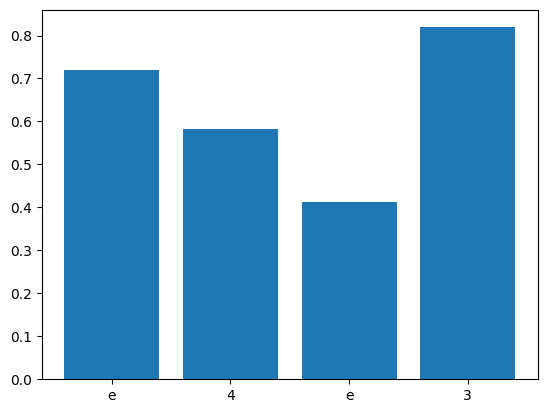

In [15]:
p = torch.softmax(logits[0, -7:-3], dim=-1)
encodings = tokenizer.decode(torch.argmax(logits[0, -7:-3], dim=-1), skip_special_tokens=True)
import matplotlib.pyplot as plt
print(p.max(-1).values)
# make a bar plot with the 4 letters as x axis and the probabilities as y axis
plt.bar(torch.arange(len(p)), torch.max(p, -1).values.detach().cpu().numpy())
plt.xticks(torch.arange(len(p)), list(encodings.strip()))

In [17]:
import chess
from typing import List

def get_legal_moves(moves: List[str]):
    """
    Given a list of moves, return the legal moves for the last move.
    """
    board = chess.Board()
    if len(moves) == 0:
        return [move.uci() for move in board.legal_moves]
    
    for move in moves:
        board.push(chess.Move.from_uci(move))
    legal_moves = [move.uci() for move in board.legal_moves]
    return legal_moves


def generate_prompts(moves: List[str], legal_moves: List[str]):
    start_instruction = "Make the opening move in a chess game. Produce the next move in UCI format to win the game"
    inbetween_instructions = "You are given a set of chess moves in UCI format. Produce the next move in UCI format to win the game"
    for legal_move in legal_moves:
        if len(moves) == 0:
            instruction = start_instruction
            inpt = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
        else:
            instruction = inbetween_instructions
            inpt = moves[:]
            inpt.append(legal_move)
            inpt = " ".join(inpt)
            inpt = " " + inpt + " "
            
        output = legal_move
        output = " " + output + " "
        text = alpaca_prompt.format(instruction, inpt, output) + EOS_TOKEN
        yield text
    
prompt = dataset[0]["text"].split("\n")
game_moves = prompt[6].strip().split(" ")
print(prompt[-1])
print(game_moves)

def chess_bot(past_moves: List[str], legal_moves: List[str]):
    torch.cuda.empty_cache()
    probs = np.zeros(len(legal_moves))
    for idx, prompt in enumerate(generate_prompts(past_moves, legal_moves)):
        input_encodings = tokenizer([prompt], return_tensors='pt', padding=True)

        with torch.no_grad():
            input_encodings = {k: v.to("cuda") for k, v in input_encodings.items()}
            output = lightning_model._model.forward(**input_encodings)
        logits = output.logits
        distr = torch.softmax(logits[0, -7:-3], dim=-1)
        p = torch.max(distr, -1).values
        encodings = tokenizer.decode(torch.argmax(distr, dim=-1), skip_special_tokens=True)
        print("pred enc", encodings, "prompt move", prompt.split("\n")[-1].split(" ")[1], "prob", p.prod().item())
        probs[idx] = p.prod().item()
    return legal_moves[np.argmax(probs)]
chess_bot(game_moves, get_legal_moves(game_moves))

 b7c8 <|eot_id|>
['d2d4', 'f7f5', 'g2g3', 'g7g6', 'f1g2', 'f8g7', 'g1f3', 'd7d6', 'c2c3', 'e7e6', 'a2a4', 'g8f6', 'd1c2', 'd8e7', 'b1d2', 'e6e5', 'd4e5', 'd6e5', 'e2e4', 'b8c6', 'e1g1', 'f5e4', 'd2e4', 'c8f5', 'f3d2', 'e8c8', 'b2b4', 'g7h6', 'f1e1', 'h6d2', 'c1d2', 'f6e4', 'g2e4', 'e7e6', 'd2g5', 'd8d6', 'a1d1', 'd6d1', 'e1d1', 'h7h6', 'g5e3', 'a7a5', 'c2b1', 'h6h5', 'b4b5', 'c6e7', 'e3g5', 'h8e8', 'h2h4', 'e6c4', 'd1e1', 'f5e4', 'e1e4', 'c4e6', 'g5f4', 'e6f5', 'f4e5', 'e7d5', 'b1e1', 'd5b6', 'f2f4', 'b6d7', 'e1e2', 'b7b6', 'e4e3', 'e8e7', 'e3e4', 'd7c5', 'e4d4', 'e7d7', 'g1g2', 'c8d8', 'g2h2', 'd8c8', 'e2g2', 'c8b8', 'g2a2', 'b8a7', 'a2g2', 'a7b8', 'g2e2', 'b8c8', 'e2f3', 'c8b8', 'f3d1', 'b8c8', 'd1e2', 'c8b8', 'e2d1', 'b8b7', 'd4d7', 'c5d7', 'e5d4', 'd7c5', 'h2g2', 'f5d5', 'g2g1', 'd5f5', 'd4c5', 'f5c5', 'd1d4', 'c5f5', 'd4d2', 'f5b1', 'g1f2', 'b1b3', 'd2d4', 'b3c2', 'f2e3']
pred enc  e4c8 prompt move b7c8 prob 0.06873352825641632
pred enc  e4b8 prompt move b7b8 prob 0.05608874559402

'c2b3'

In [113]:
pipe = pipeline(
    "text-generation",
    model=lightning_model._model,
    tokenizer=lightning_model._tokeniser,
)

messages = [
    {"role": "system", "content": "Make the opening move in a chess game. Produce the next move in UCI format to win the game"},
    {"role": "user", "content": "You are given a set of chess moves in UCI format. Produce the next move in UCI format to win the game\n\n### Input:\n d2d4 f7f5 g2g3 g7g6 f1g2 f8g7 g1f3 d7d6 c2c3 e7e6 a2a4 g8f6 d1c2 d8e7 b1d2 e6e5 d4e5 d6e5 e2e4 b8c6 e1g1 f5e4 d2e4 c8f5 f3d2 e8c8 b2b4 g7h6 f1e1 h6d2 c1d2 f6e4 g2e4 e7e6 d2g5 d8d6 a1d1 d6d1 e1d1 h7h6 g5e3 a7a5 c2b1 h6h5 b4b5 c6e7 e3g5 h8e8 h2h4 e6c4 d1e1 f5e4 e1e4 c4e6 g5f4 e6f5 f4e5 e7d5 b1e1 d5b6 f2f4 b6d7 e1e2 b7b6 e4e3 e8e7 e3e4 d7c5 e4d4 e7d7 g1g2 c8d8 g2h2 d8c8 e2g2 c8b8 g2a2 b8a7 a2g2 a7b8 g2e2 b8c8 e2f3 c8b8 f3d1 b8c8 d1e2 c8b8 e2d1 b8b7 d4d7 c5d7 e5d4 d7c5 h2g2 f5d5 g2g1 d5f5 d4c5 f5c5 d1d4 c5f5 d4d2 f5b1 g1f2 b1b3 d2d4 b3c2 f2e3 b7c8 d4h8 c8b7 h8d4 b7b8 d4d8 b8b7 d8d5 b7b8 d5g8 b8b7 g8c4 b7b8 c4g8 b8b7 g8d5 b7b8 d5d8 b8b7 d8d4 b7b8 d4d8 b8b7 d8d3 c2a4 d3g6 a4b5 g6e4 b7a7 f4f5 a5a4 f5f6 a4a3 f6f7 b5c5 e3e2 a7b8"},
]

generation_args = {
    "max_new_tokens": 600,
    "return_full_text": False,
    "temperature": 0.3,
}
print(type(pipe))
output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

Device set to use cuda


<class 'transformers.pipelines.text_generation.TextGenerationPipeline'>
c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3 b5c5 e3e4 c5b5 e4e3
